downloaded `bc-30.out` from [RCSB FTP archive](https://www.rcsb.org/pages/download/ftp). It contains 404955 chains, clustered in 27927 lines.


## Scaling
See [Refmac paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3069751/), where one minimizes
$\sum|F_o - F_{total}|^{2}$, with 
$$
\begin{eqnarray}
F_{total} &=& k_{overall}k_{aniso}(1-k_{Babinet})(F_{protein}+k_{mask}F_{mask})\\\nonumber
&& k_{overal} = k_{overall0}\exp (-B_{overall}|s|{^2})\\\nonumber
&& k_{Babinet} = k_{Babinet0}\exp (-B_{Babinet}|s|{^2})\\\nonumber
&& k_{mask} = k_{mask0}\exp (-B_{mask}|s|{^2})\\\nonumber
&& k_{aniso} = \exp (-s^{T} U_{aniso}s), tr(U)=0\\\nonumber
\end{eqnarray}
$$

### INPUT

**Solvent mask calculation**
SOLVENT [YES|NO] [VDWProb <vdwprob>] [IONProb <ionprob >] [RSHRink <rshrink>]
    
*default is use the bulk solvent correction based on a constant value with the parameters of the mask VDWProb=1.4, IONProbe=0.8, RSHRink=0.8*

[more info here](https://www2.mrc-lmb.cam.ac.uk/groups/murshudov/content/refmac/refmac_keywords.html#id.b236767394ac)

**Scaling**

SCALE TYPE BULK is default and uses Babinet's bulk solvent, even when SOLVENT is set to NO.
scale type bulk
scale lsscalle fixbulk bvalue <value> scale <scale>
    
SCALE TYPE SIMPLE does not use Babinet's bulk solvent.


    
### OUTPUT

[link](http://www.ccp4.ac.uk/html/refmac5/files/log.html#input_def) 
Scale and sigmaA parameters
REFMAC prints out the scale and sigmaA parameters at every cycle. However, if anisotropic scale is used it is estimated at the first cycle only. For example:

```
[Least-square output?]
Overall               : scale =   0.604, B  =  -0.050
Babinet's bulk solvent: scale =   0.299, B  = 200.000
Partial structure    1: scale =   0.727, B  =  13.532 # <=== mask scaling parameters
Overall anisotropic scale factors
   B11 =  0.98 B22 = -0.91 B33 =  0.21 B12 =  0.00 B13 =  0.31 B23 =  0.00
[maximum-likelihood output?]
Overall sigmaA parameters  : sigmaA0 =   0.930, B_sigmaA  =   2.136
Babinet's scale for sigmaA : scale =    -0.191, B  =        150.000
SigmaA fo partial structure   1: scale =   0.304, B  =  56.473
```


## Hydrophobicity measures

Atomic Solvation Parameters for solvation energy. Build on AquaSAXS engine for atom type recognition, and SASA calculation, and add the ASP from Eisenberg & Machlahlan for example. See these: [0](https://onlinelibrary.wiley.com/doi/pdf/10.1002/pro.5560041206) [1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2142195/pdf/1304905.pdf) [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2373680/pdf/0111984.pdf) [3](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.711.7189&rep=rep1&type=pdf) [4](http://charmm.sunhwanj.com/html/aspenr.html) [5](https://www.ncbi.nlm.nih.gov/pubmed/3945310) [6](https://onlinelibrary.wiley.com/doi/epdf/10.1002/prot.340200307)

We could try sorting structure by their average surface tension $\bar{\sigma} = \frac{\sum_{i}\sigma_{i}A_{i}}{\sum_{i}A_{i}}$, as well as hydrophobic accessible surface ratio $r = \frac{\sum_{i}\frac{sign(\sigma_{i})+1}{2} A_{i}}{\sum_{i}A_{i}}$

# Results

We load here the data from `summary.log`

In [65]:
filename="../pdb-scan/summary.log"
data, index, n_var, n_sample = load_data(filename)
#print(index[0], data[0,:])

n_sample:  9844  n_var:  9


In the following, we extract the following from each PDB ID.

**PDB model**

each atom $i$ from the PDB model has an associated solvent exposed surface are $A_{i}$ and an atomic solvation parameter $\sigma_{i}$ whose value depend on its type (carbon, nitrogen, oxygen, neutral, charged, ...). Positive means more hydrophobic than negative values.

**Structure factors**

We ran Refmac (without iterating) in 3 modes, without solvent flattening (NO), with Babinet only (BAB), with the whole package (ALL). For each, we got a R(q) profile.

**Summary**

The columns are as follow:
- 1) PDB ID
- 2) Average surface tension $\frac{\sum_{i}\sigma_{i}A_{i}}{\sum_{i}A_{i}}$
- 3) Hydrophobic surface ratio $\frac{\sum_{i}(\text{sign}(\sigma_{i})+1)A_{i}}{2\sum_{i}A_{i}}$
- 4) Deviation of R from nothing to Babinet $\int dq \big(R_{BAB}(q) - R_{NO}(q)\big)$
- 5) Deviation of R from nothing to all $\int dq \big(R_{ALL}(q) - R_{NO}(q)\big)$
- 6) Lowest resolution shell $q_{min}$
- 7) Highest resolution shell $q_{max}$
- 8) Average R factor without solvent model $R_{NO}$
- 9) Average R factor with Babinet $R_{BAB}$
- 10) Average R factor with full solvent $R_{ALL}$

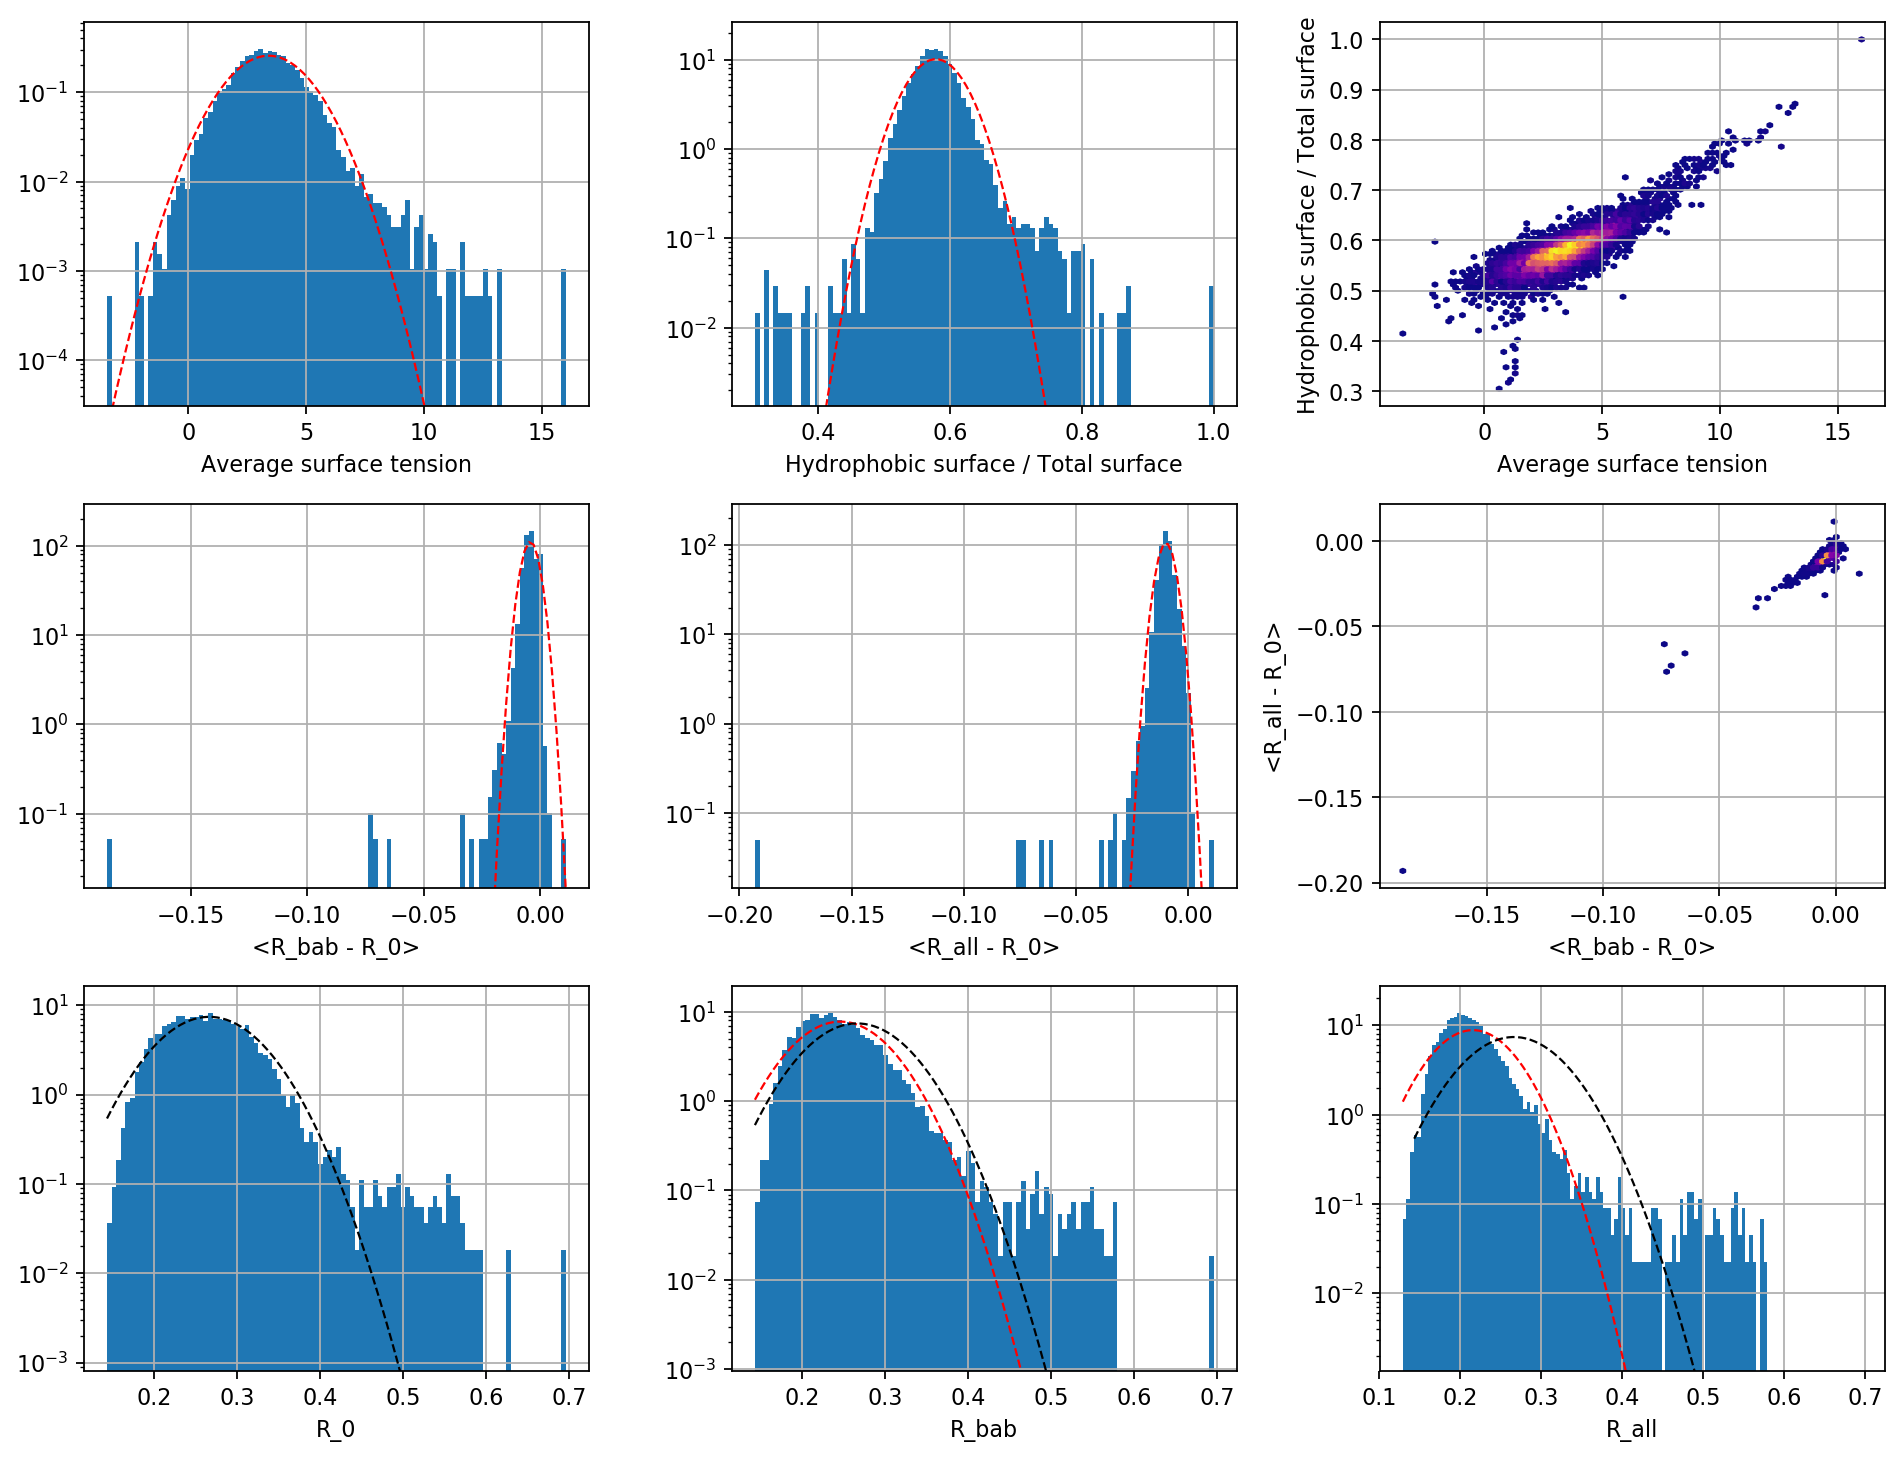

In [91]:
nbins=100
plot_summary(data,nbins)

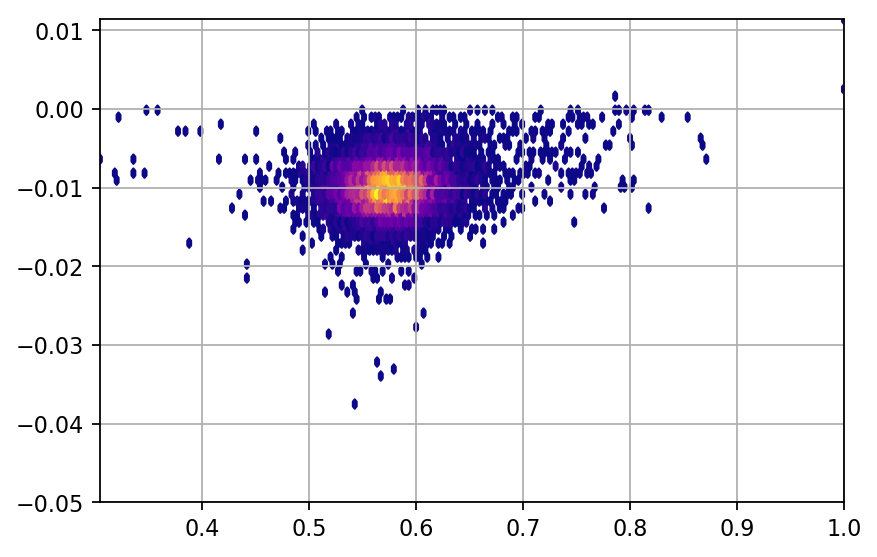

In [89]:
#i=0 # Average surface tension
i=1 # Hydrophobic surface ratio
#j=2 # <R_bab - R_0>
j=3 # <R_all - R_0>
xmin=np.min(data[:,i])
xmax=np.max(data[:,i])
ymin=-0.05 #np.min(data[:,j])
ymax=np.max(data[:,j])
nbins=200
plot_scatter_component_analysis_onepair(data[:,i],data[:,j],xmin,xmax,ymin,ymax,nbins)

# Toolkits

In [90]:
# Useful libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import FastICA, PCA
import scipy
import scipy.spatial
import scipy.cluster
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [86]:
### I/O FUNCTIONS ###
def load_data(filename):
    # Loading raw data
    #raw = genfromtxt(filename, delimiter=' ')
    data = genfromtxt(filename, comments='#', usecols=(1,2,3,4,5,6,7,8,9) , dtype=(float))
    index = genfromtxt(filename, comments='#', usecols=(0) , dtype=(str))
    #index=raw[:,0]
    #data=raw[:,1:]
    n_sample, n_var = data.shape
    print("n_sample: ",n_sample, " n_var: ",n_var)
    #
    return data, index, n_var, n_sample

### PLOT FUNCTIONS
def plot_summary(data,nbins):
    plt.figure(figsize=(12, 12), dpi= 160, facecolor='w', edgecolor='k')
    nrow=4
    ncol=3
# SURFACE TERMS
    plt.subplot(nrow,ncol,1)
    qty=data[:,0]
    n, bins, patches = plt.hist(qty,nbins,density=True,log=True)
    (mu, sigma) = norm.fit(qty)
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=1)
    plt.grid()
    plt.xlabel('Average surface tension')
    plt.ylim(ymin=np.max(n)*1e-4)
    plt.ylim(ymax=np.max(n)*2)
    #
    plt.subplot(nrow,ncol,2)
    qty=data[:,1]
    n, bins, patches = plt.hist(qty,nbins,density=True,log=True)
    (mu, sigma) = norm.fit(qty)
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=1)
    plt.grid()
    plt.xlabel('Hydrophobic surface / Total surface')
    plt.ylim(ymin=np.max(n)*1e-4)
    plt.ylim(ymax=np.max(n)*2)
    #
    plt.subplot(nrow,ncol,3)
    plt.grid()
    Ax=data[:,0]
    Ay=data[:,1]
    plt.xlabel('Average surface tension')
    plt.ylabel('Hydrophobic surface / Total surface')
    plt.hexbin(Ax, Ay, gridsize=nbins, cmap='plasma', mincnt=1)
# dR TERMS
    plt.subplot(nrow,ncol,4)
    qty=data[:,2]
    n, bins, patches = plt.hist(qty,nbins,density=True,log=True)
    (mu, sigma) = norm.fit(qty)
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=1)
    plt.grid()
    plt.xlabel('<R_bab - R_0>')
    plt.ylim(ymin=np.max(n)*1e-4)
    plt.ylim(ymax=np.max(n)*2)
    #
    plt.subplot(nrow,ncol,5)
    qty=data[:,3]
    n, bins, patches = plt.hist(qty,nbins,density=True,log=True)
    (mu, sigma) = norm.fit(qty)
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=1)
    plt.grid()
    plt.xlabel('<R_all - R_0>')
    plt.ylim(ymin=np.max(n)*1e-4)
    plt.ylim(ymax=np.max(n)*2)
    #
    plt.subplot(nrow,ncol,6)
    plt.grid()
    Ax=data[:,2]
    Ay=data[:,3]
    plt.xlabel('<R_bab - R_0>')
    plt.ylabel('<R_all - R_0>')
    plt.hexbin(Ax, Ay, gridsize=nbins, cmap='plasma', mincnt=1)
# R factor info
    plt.subplot(nrow,ncol,7)
    qty=data[:,6]
    n, bins, patches = plt.hist(qty,nbins,density=True,log=True)
    (mu, sigma) = norm.fit(qty)
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'k--', linewidth=1)
    bno=bins
    yno=y
    plt.grid()
    plt.xlabel('R_0')
    plt.ylim(ymin=np.max(n)*1e-4)
    plt.ylim(ymax=np.max(n)*2)
    #
    plt.subplot(nrow,ncol,8)
    qty=data[:,7]
    n, bins, patches = plt.hist(qty,nbins,density=True,log=True)
    (mu, sigma) = norm.fit(qty)
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=1)
    lno = plt.plot(bno, yno, 'k--', linewidth=1)
    plt.grid()
    plt.xlabel('R_bab')
    plt.ylim(ymin=np.max(n)*1e-4)
    plt.ylim(ymax=np.max(n)*2)
    #
    plt.subplot(nrow,ncol,9)
    qty=data[:,8]
    n, bins, patches = plt.hist(qty,nbins,density=True,log=True)
    (mu, sigma) = norm.fit(qty)
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=1)
    lno = plt.plot(bno, yno, 'k--', linewidth=1)
    plt.grid()
    plt.xlabel('R_all')
    plt.ylim(ymin=np.max(n)*1e-4)
    plt.ylim(ymax=np.max(n)*2)
#
    plt.tight_layout()
    plt.show()
#    
def plot_scatter_component_analysis_onepair(Ax,Ay,xmin,xmax,ymin,ymax,nbins):
    fig = plt.figure(figsize=(6, 4), dpi= 160, facecolor='w', edgecolor='k')
    xlim_array = [xmin, xmax]
    ylim_array = [ymin, ymax]
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim_array)
    ax.set_ylim(ylim_array)
    plt.grid()
    #plt.scatter(Ax, Ay, cmap='rainbow')
    plt.hexbin(Ax, Ay, gridsize=nbins, cmap='plasma', mincnt=1)
    plt.show()
#